<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# MTBS Fire Data

_by Jeremy Freeman (CarbonPlan), November 28, 2020_

We have produced a 4km monthly fire data product from the MTBS database. 

As background, MTBS itself provides two products: raw fire perimeter shapefiles with individual fire dates, and an annual-only "burn severity" mosaic that uses LANDAST data to ascribe pixel-level severity. We combined these to obtain a monthly raster product thresholded by burn severity.

The steps to create this data product were as follows:

- Extract fire perimeters directly from MTBS shape files for all fire categories except for prescribed burns
- Create a binary raster for each month by "burning in" shapes for all fires with dates in that month
- Mask each raster with the MTBS burn severity mosaic from the corresponding year to include only moderate or high severity fires
- Aggregate from 30m to 4km with averaging, treating masked regions in the original data as missing values

We independently validated that, in any given year, the sum of this monthly dataset across months was essentially identical to the annual burn severity mosoaic product restricted to the same severity thresholds. Any differences could be explained by the fact that the existing annual product appears to include prescribed burns, whereas we have excluded them.

This notebook loads and inspects the data and demonstrates a few different kinds of queries against it.


In [1]:
import fsspec
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp
import regionmask as rm

In [2]:
%matplotlib inline
from palettable.colorbrewer.sequential import YlOrRd_9
import matplotlib.pyplot as plt
cmap = YlOrRd_9.mpl_colormap

First we load the monthly MTBS data

In [3]:
mapper = fsspec.get_mapper("gs://carbonplan-data/processed/mtbs/conus/4000m/monthly.zarr")
da = xr.open_zarr(mapper)["monthly"]
da.load();

We'll also load "supersections" which we'll use for computing regional statistics

In [4]:
regions = gp.read_file("data/supersections.geojson")

And we'll compute masks from these regions

In [5]:
masks = rm.mask_3D_geopandas(regions, da)

Now we'll demo two examples of aggregating within regions to extract historical fire statistics.

## Querying individual regions

We can use our masks to query individual regions

Text(0.5, 1.0, 'Okanogan Highland')

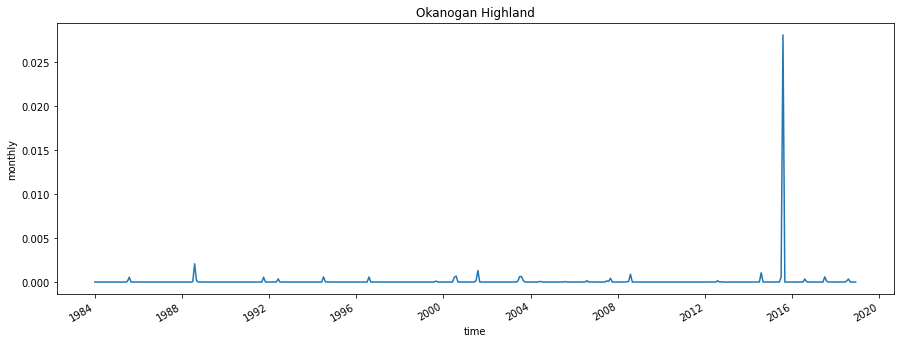

In [6]:
da.where(masks[0]).mean(['x', 'y']).plot(figsize=[15,5]);
plt.title(regions.iloc[0].SSection)

Text(0.5, 1.0, 'Northwest Cascades')

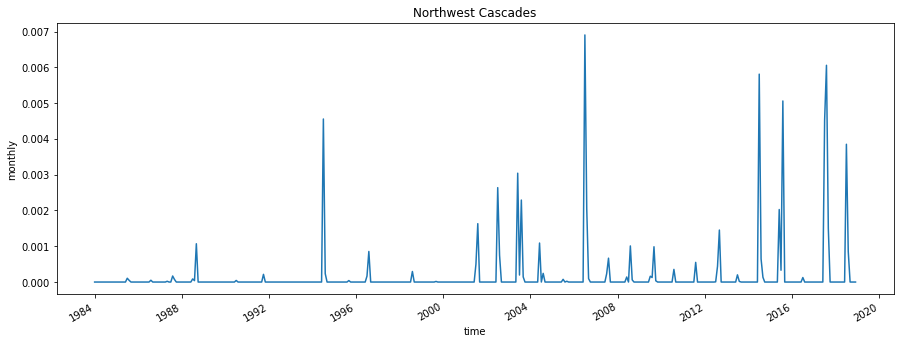

In [7]:
da.where(masks[1]).mean(['x', 'y']).plot(figsize=[15,5])
plt.title(regions.iloc[1].SSection)

We can also use the same dataset to compute annual trends. Technically, there may be differences between the following two operations:

- taking the sum over all months in a given year at 4km
- taking the sum over all months in a given year at 30m, thresholding values greater than 1, and downsampling to 4km

Specifically, if there are repeat fires within the same 30m grid cell across months, the first method will slightly overestimate the annual burn area computed using the second method. Empirically, we compared the results of these two computations, and found effectively identical outputs, with the exception of one location in one year (1996) (not shown). 

This result implies that essentially no grid cells at 30m have repeat fires across months within a given year. It also implies that we can simply sum across months in the 4km product to get annual burn rates.

Here we show annual trends for the same regions

Text(0.5, 1.0, 'Okanogan Highland')

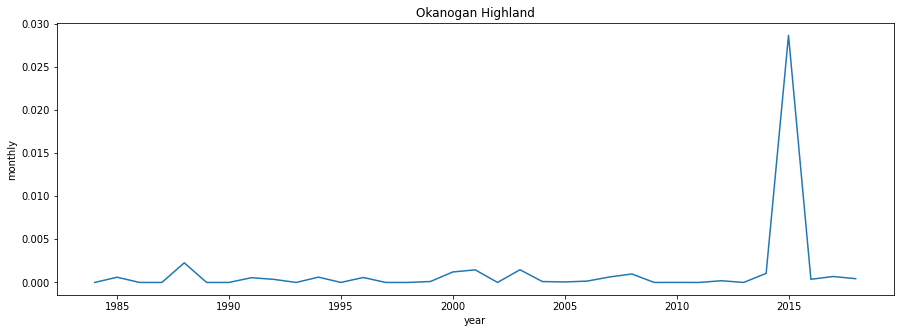

In [8]:
da.where(masks[0]).mean(['x', 'y']).groupby('time.year').sum().plot(figsize=[15,5]);
plt.title(regions.iloc[0].SSection)

Text(0.5, 1.0, 'Okanogan Highland')

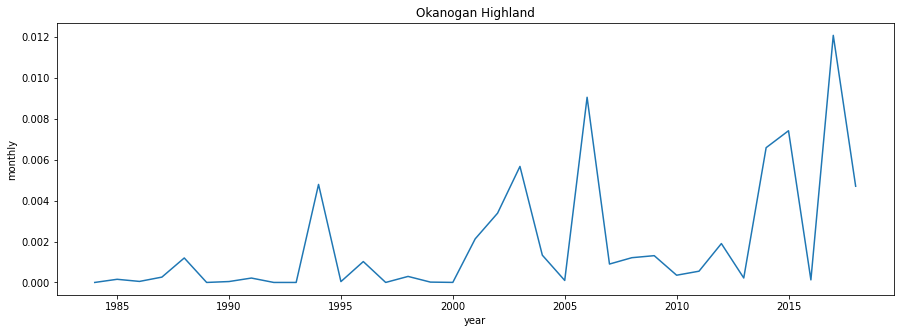

In [9]:
da.where(masks[1]).mean(['x', 'y']).groupby('time.year').sum().plot(figsize=[15,5]);
plt.title(regions.iloc[0].SSection)

## Fire statistics: reproducing Anderegg et al. (2020)

Here we show we can reproduce the analysis from Figure 5 of Anderegg et al. (2020) with this new data product. That analysis used MTBS's annual rasters, but here we find the results are essentially identical (and now that we're using `xarray`, the code got a lot simpler!)

First define a function for converting annual risk to an "100-year risk", which estimates the probability of at least 1 fire in 100 years if all fires have a risk equal to the historical burn rate for that region.

In [10]:
from scipy.stats import binom
def integrated_risk(p):
    return (1 - binom.cdf(0, 100, p)) * 100

To look at the period from 1984 to 2000, first we sum within each year, and then average across years.

In [11]:
before_2000 = da.sel(time=slice('1984','2000')).groupby('time.year').sum().mean('year')

Use our masks to compute the mean within each region

In [12]:
risks_before_2000 = np.asarray(
    [before_2000.where(masks.sel(region=i)).mean(['x','y']).values.item() for i in masks['region']]
)

And then plot

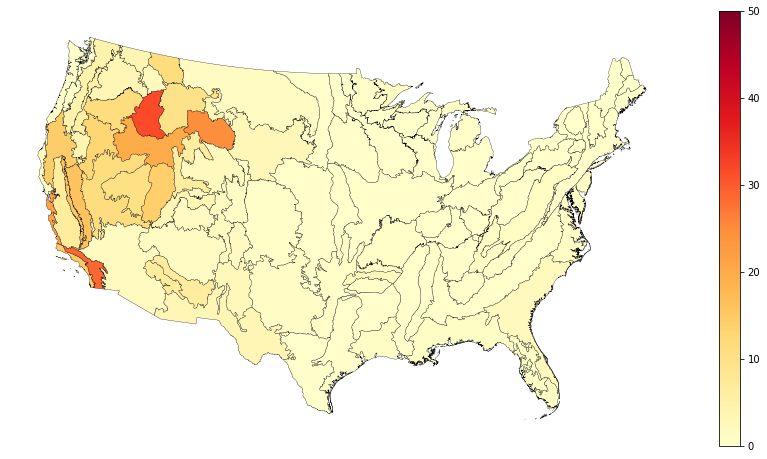

In [13]:
regions.to_crs('EPSG:5070').plot(
    integrated_risk(risks_before_2000), figsize=[15, 8], cmap=cmap, 
    edgecolor=[0,0,0], linewidth=0.3, vmin=0, vmax=50, legend=True
)
plt.axis('off');

Now do the same thing for the period from 2001 to 2018

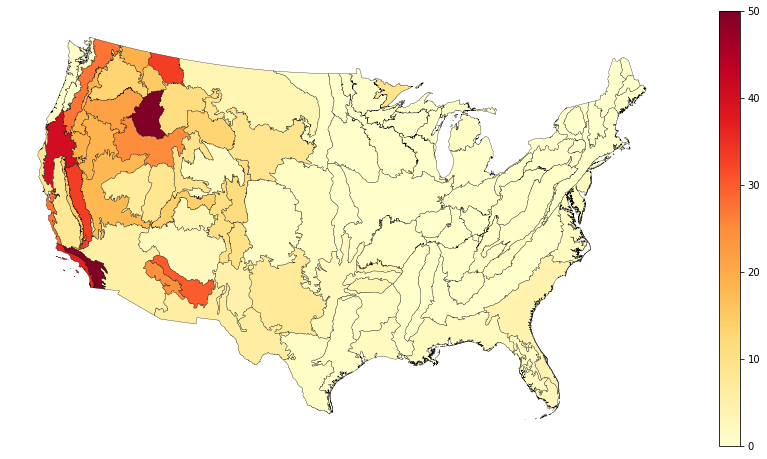

In [14]:
after_2000 = da.sel(time=slice('2001','2017')).groupby('time.year').sum().mean('year')
risks_after_2000 = np.asarray(
    [after_2000.where(masks.sel(region=i)).mean(['x','y']).values.item() for i in masks['region']]
)
regions.to_crs('EPSG:5070').plot(
    integrated_risk(risks_after_2000), figsize=[15, 8], cmap=cmap, 
    edgecolor=[0,0,0], linewidth=0.3, vmin=0, vmax=50, legend=True
)
plt.axis('off');

You can confirm these look essentially identical to the published Figure 5.